In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

In [4]:
df = pd.read_excel("premiums_rest.xlsx")
df.head(3)

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164


In [5]:
df.shape

(29904, 13)

In [6]:
df.columns

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical History', 'Insurance_Plan',
       'Annual_Premium_Amount'],
      dtype='object')

In [7]:
df.columns = df.columns.str.replace(" ", "_").str.lower()
df.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164


In [8]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           9
employment_status        1
income_level             9
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [9]:
df.dropna(inplace=True)

## Handle NA Values

In [10]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [11]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [12]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29886.000000,29886.000000,29886.000000,29886.000000
mean,43.396105,2.379910,23.364184,20892.303821
std,13.412657,1.431201,24.740339,6936.813440
min,26.000000,-3.000000,1.000000,3625.000000
25%,34.000000,1.000000,7.000000,15697.250000
50%,42.000000,3.000000,17.000000,20489.000000
75%,52.000000,3.000000,32.000000,26360.000000
max,356.000000,5.000000,930.000000,43471.000000


In [13]:
df[df.number_of_dependants < 0].shape
df[df.number_of_dependants < 0]["number_of_dependants"].unique()

array([-1, -3])

In [14]:
df["number_of_dependants"] = abs(df["number_of_dependants"])
df["number_of_dependants"].describe()

count    29886.000000
mean         2.385933
std          1.421137
min          0.000000
25%          1.000000
50%          3.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

In [15]:
numeric_columns = df.select_dtypes(["float64", "int64"]).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

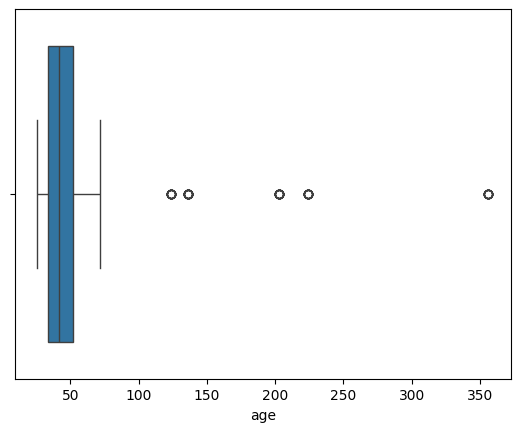

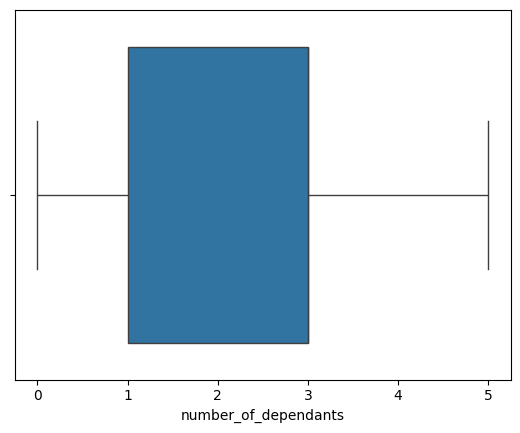

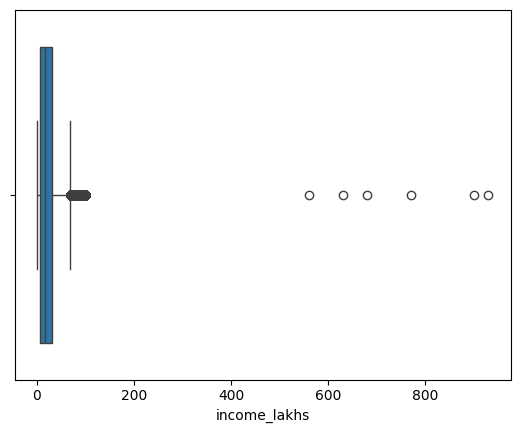

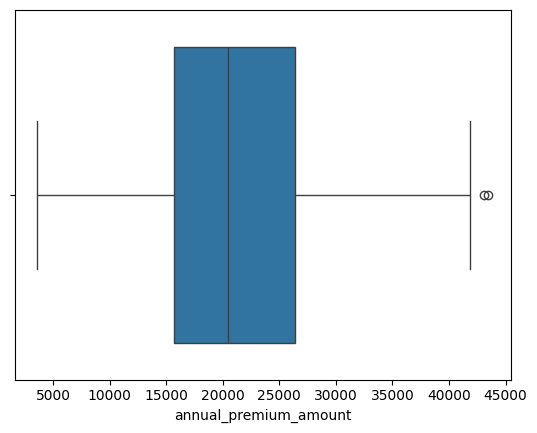

In [16]:
for col in numeric_columns:
    sns.boxplot(x=df[col])
    plt.show()

In [17]:
df[df.age > 100]["age"].unique()

array([224, 124, 136, 203, 356])

In [18]:
df1 = df[df.age <= 100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29828.000000,29828.000000,29828.000000,29828.000000
mean,43.095380,2.387790,23.371530,20901.900563
std,11.041991,1.420641,24.751262,6928.457636
min,26.000000,0.000000,1.000000,6538.000000
25%,34.000000,1.000000,7.000000,15706.000000
50%,42.000000,3.000000,17.000000,20496.000000
75%,52.000000,3.000000,32.000000,26361.000000
max,72.000000,5.000000,930.000000,43471.000000


<Axes: xlabel='income_lakhs', ylabel='Count'>

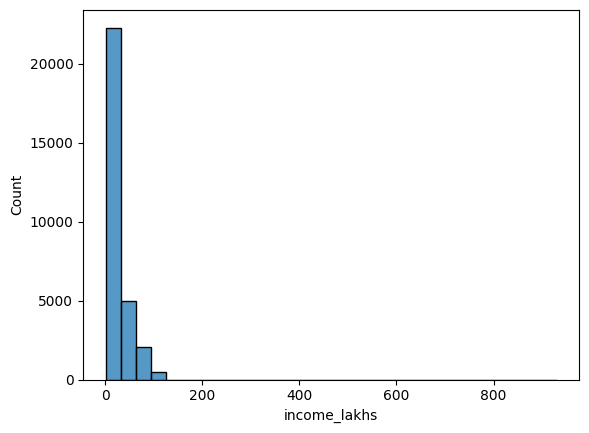

In [19]:
sns.histplot(df1.income_lakhs, bins=30)

In [20]:
df1.income_lakhs.quantile([0.25, 0.75])

0.25     7.0
0.75    32.0
Name: income_lakhs, dtype: float64

In [21]:
def get_iqr_bounds(col):
    q1 = col.quantile(0.25)
    q3 = col.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound

In [22]:
get_iqr_bounds(df1.income_lakhs)

(np.float64(-30.5), np.float64(69.5))

In [23]:
quantile_threshold = df1.income_lakhs.quantile(0.999)
quantile_threshold

np.float64(100.0)

In [24]:
df2 = df1[df1.income_lakhs <= quantile_threshold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29822.000000,29822.000000,29822.000000,29822.000000
mean,43.094896,2.387734,23.226343,20900.689223
std,11.042430,1.420644,22.455408,6928.192115
min,26.000000,0.000000,1.000000,6538.000000
25%,34.000000,1.000000,7.000000,15705.250000
50%,42.000000,3.000000,17.000000,20495.500000
75%,52.000000,3.000000,32.000000,26360.000000
max,72.000000,5.000000,100.000000,43471.000000


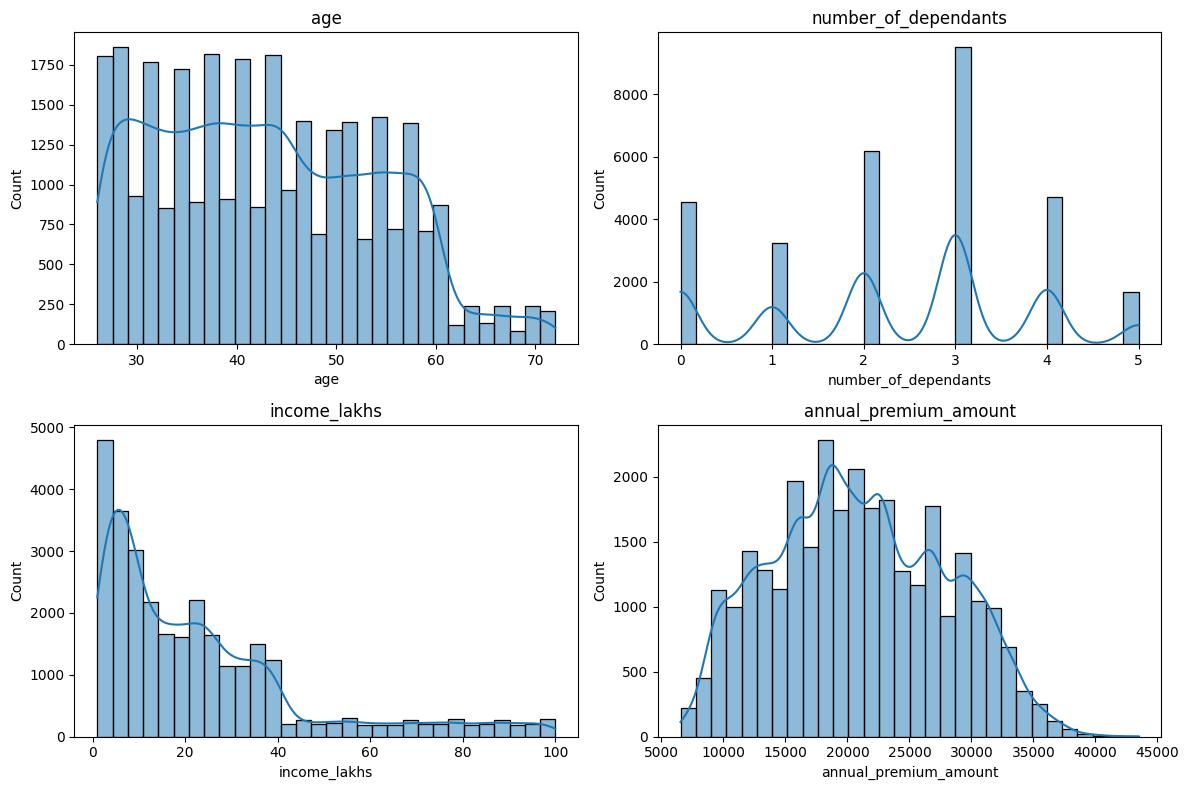

In [25]:
# Define the number of columns per row
num_cols = 2
num_plots = len(numeric_columns)
num_rows = (
    num_plots + num_cols - 1
) // num_cols  # To calculate the required number of rows

fig, axes = plt.subplots(
    num_rows, num_cols, figsize=(12, num_rows * 4)
)  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the axes array

for i, col in enumerate(numeric_columns):
    sns.histplot(
        x=df2[col], kde=True, bins=30, ax=axes[i]
    )  # Plot in the respective subplot
    axes[i].set_title(col)

# Remove any empty subplots if num_plots is odd
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

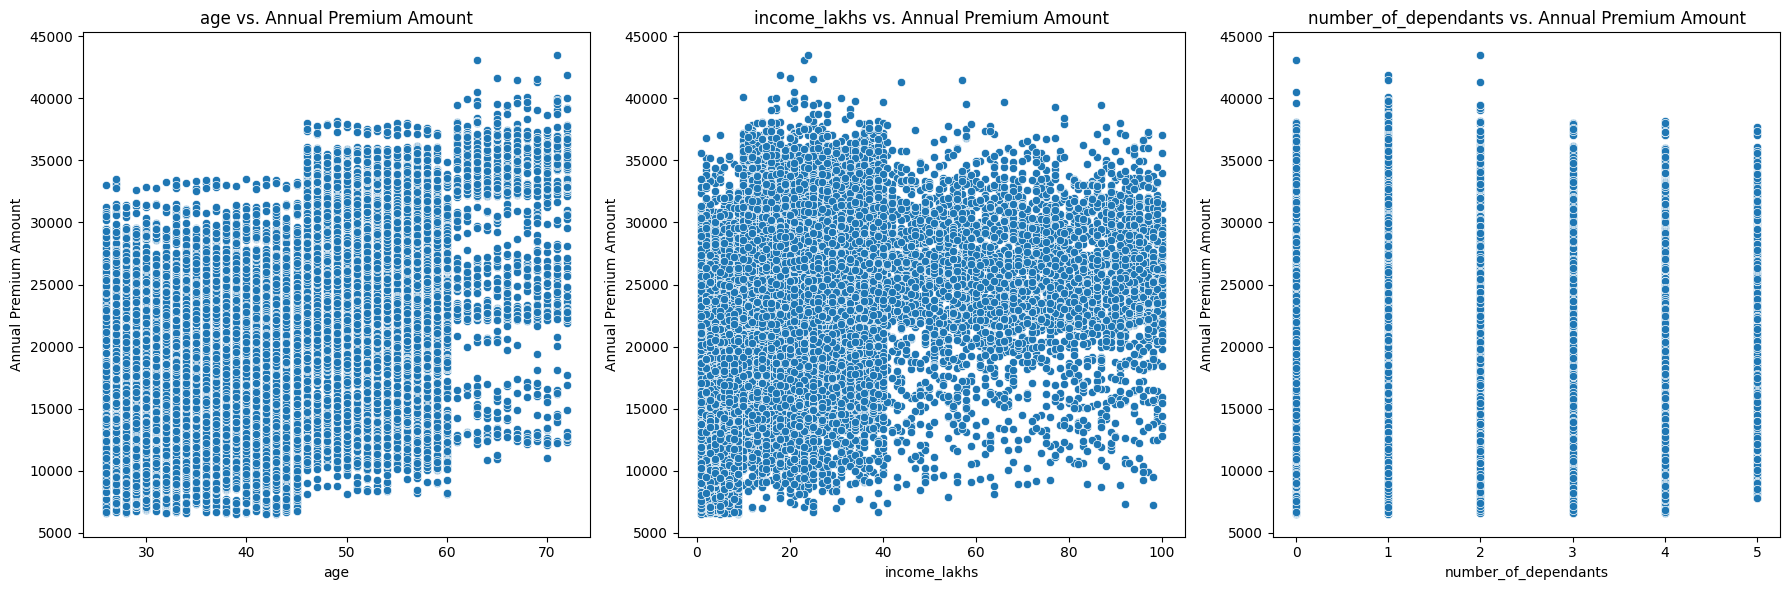

In [26]:
numeric_features = ["age", "income_lakhs", "number_of_dependants"]

fig, axes = plt.subplots(
    1, len(numeric_features), figsize=(18, 6)
)  # Adjust figure size as necessary

for ax, column in zip(axes, numeric_features):
    sns.scatterplot(x=df2[column], y=df2["annual_premium_amount"], ax=ax)
    ax.set_title(f"{column} vs. Annual Premium Amount")
    ax.set_xlabel(column)
    ax.set_ylabel("Annual Premium Amount")

plt.tight_layout()  # Adjust layout
plt.show()

In [27]:
categorical_cols = [
    "gender",
    "region",
    "marital_status",
    "bmi_category",
    "smoking_status",
    "employment_status",
    "income_level",
    "medical_history",
    "insurance_plan",
]
for col in categorical_cols:
    print(col, ":", df2[col].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Does Not Smoke' 'Not Smoking'
 'Smoking=0']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


In [28]:
df2["smoking_status"].replace(
    {
        "Not Smoking": "No Smoking",
        "Does Not Smoke": "No Smoking",
        "Smoking=0": "No Smoking",
    },
    inplace=True,
)

df2["smoking_status"].unique()

C:\Users\sakif\AppData\Local\Temp\ipykernel_49964\1907065380.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2["smoking_status"].replace(


array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

In [29]:
pct_count = df2["gender"].value_counts(normalize=True)
pct_count

gender
Male      0.549125
Female    0.450875
Name: proportion, dtype: float64

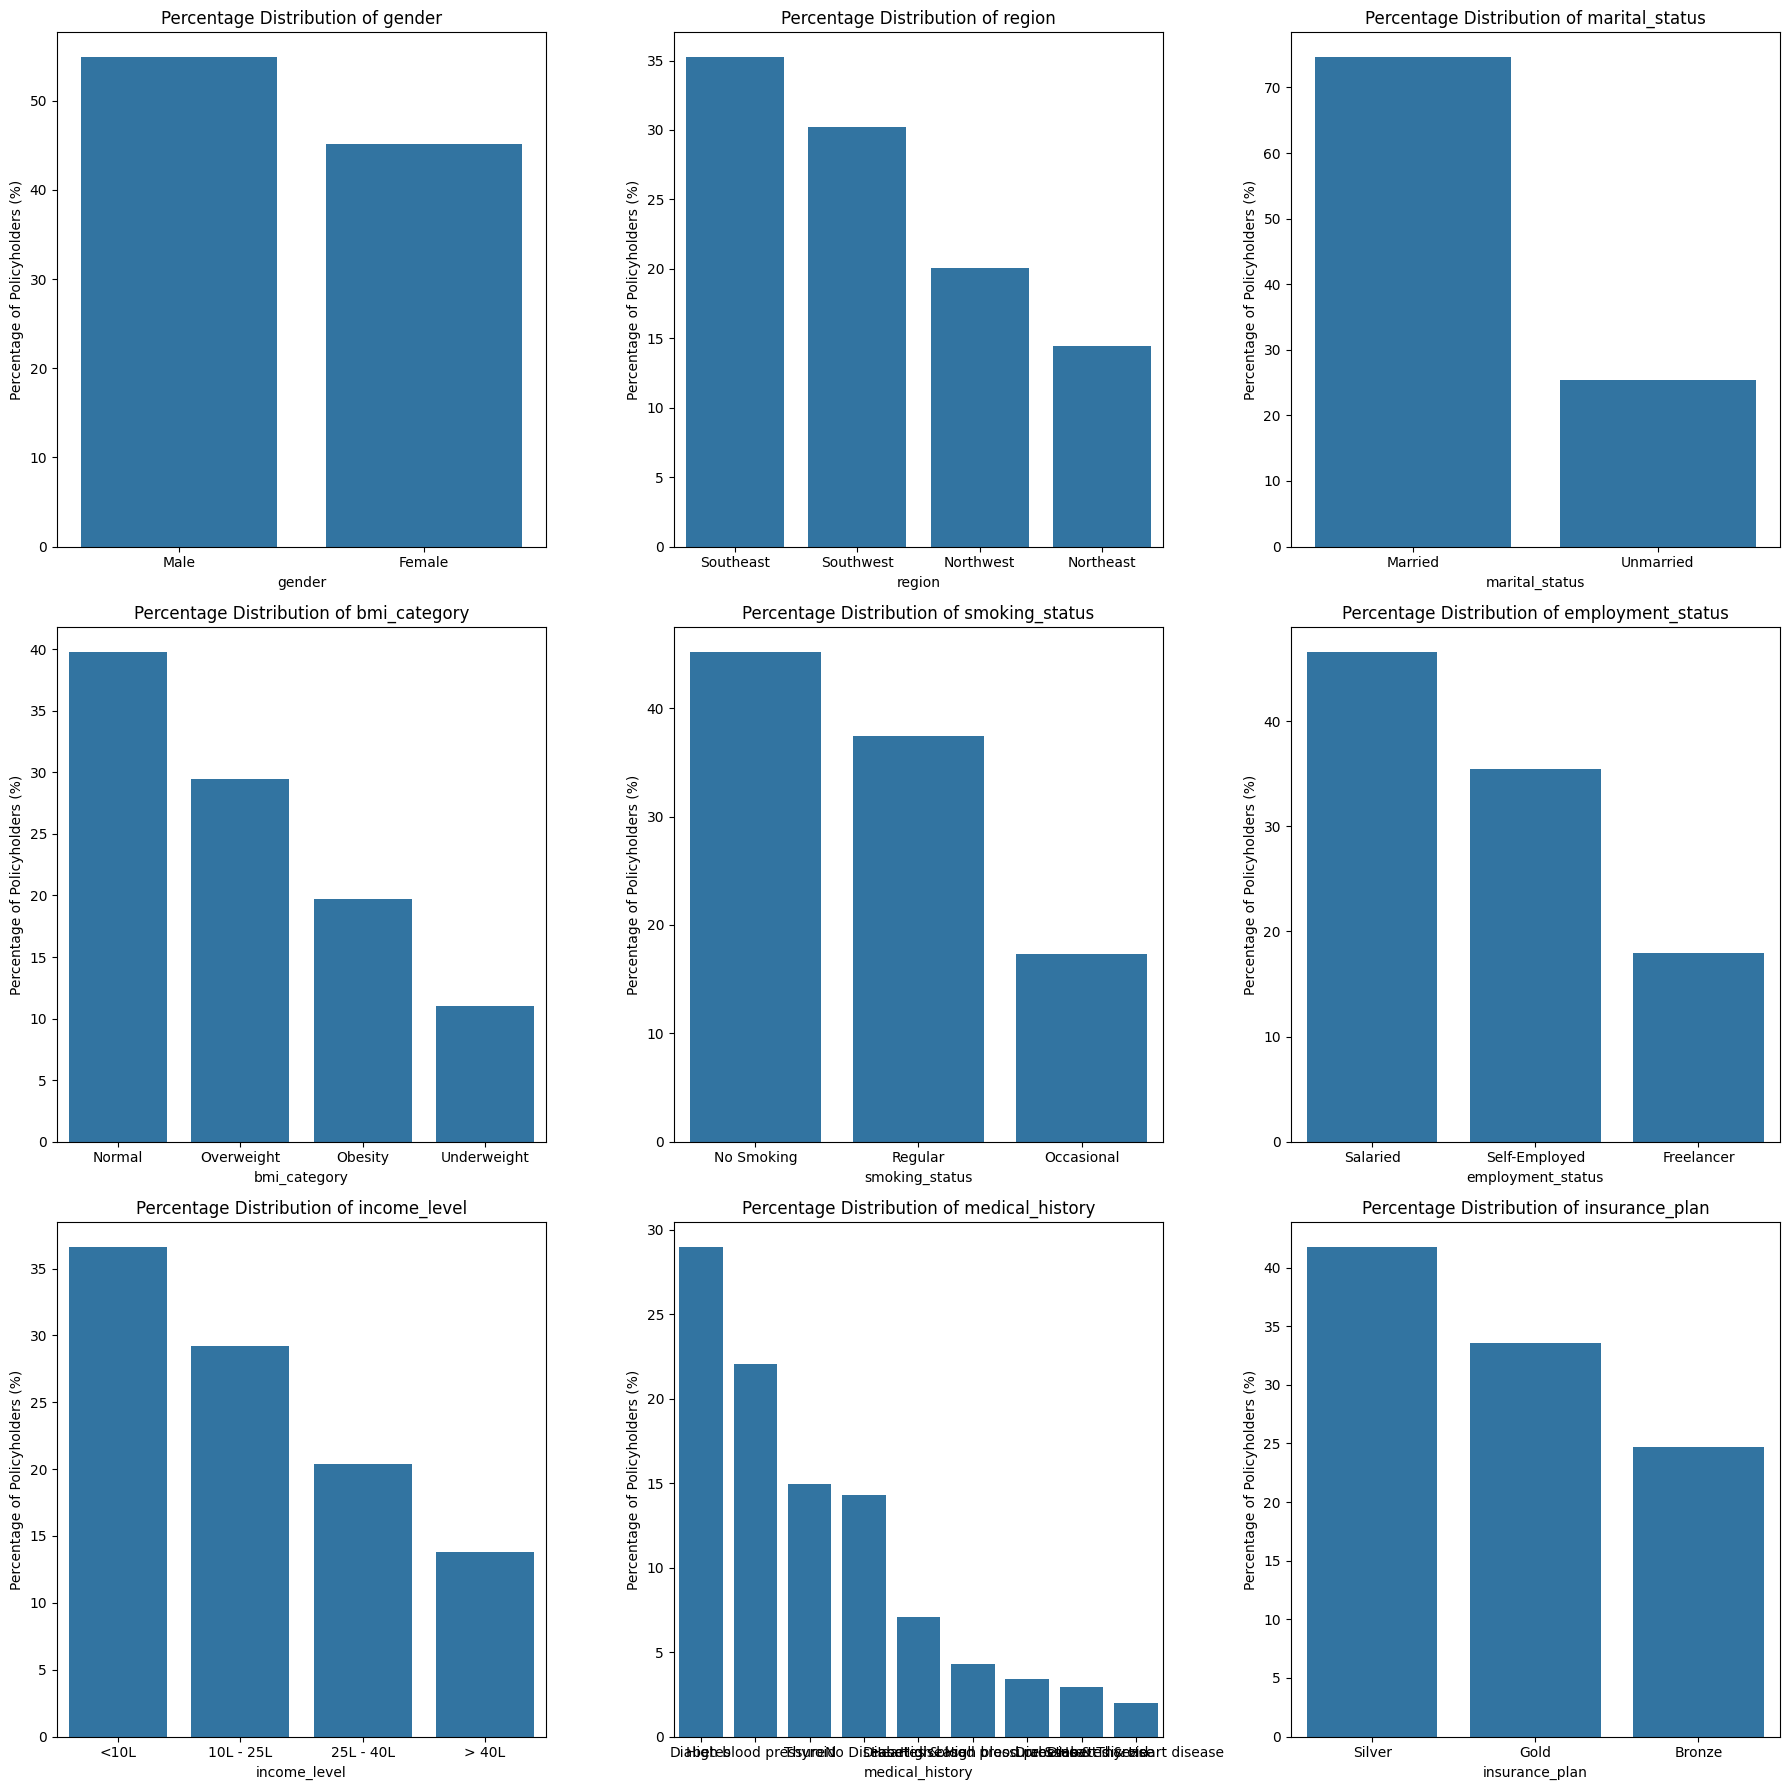

In [30]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))  # Adjust figure size as necessary
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for ax, column in zip(axes, categorical_cols):
    # Calculate the percentage distribution of each category
    category_counts = (
        df2[column].value_counts(normalize=True) * 100
    )  # normalize=True gives the relative frequencies

    # Plotting the distribution using barplot
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax)
    ax.set_title(f"Percentage Distribution of {column}")
    ax.set_ylabel("Percentage of Policyholders (%)")
    ax.set_xlabel(column)  # Set xlabel to the column name for clarity

plt.tight_layout()  # Adjusts plot parameters for better fit in the figure window
plt.show()

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L          799  3554    4354
25L - 40L          301  2631    3142
<10L              6054   527    4341
> 40L              214  3287     618


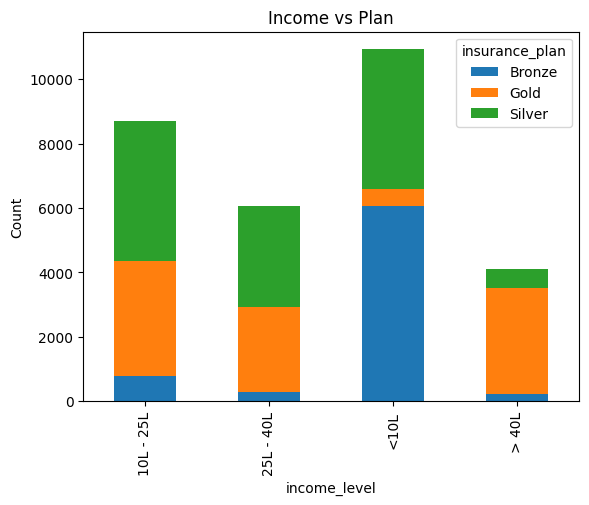

In [31]:
# Cross-tabulation of gender and smoking status
crosstab = pd.crosstab(df2["income_level"], df2["insurance_plan"])
print(crosstab)

# Plotting the crosstab
crosstab.plot(kind="bar", stacked=True)
plt.title("Income vs Plan")
plt.ylabel("Count")
plt.show()

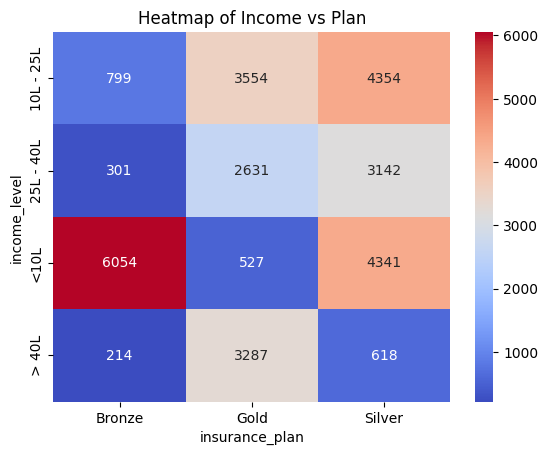

In [32]:
sns.heatmap(crosstab, annot=True, cmap="coolwarm", fmt="d")
plt.title("Heatmap of Income vs Plan")
plt.show()

In [33]:
df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164


In [34]:
df2.medical_history.value_counts()

medical_history
Diabetes                               8644
High blood pressure                    6580
Thyroid                                4453
No Disease                             4265
Heart disease                          2116
Diabetes & High blood pressure         1288
High blood pressure & Heart disease    1010
Diabetes & Thyroid                      881
Diabetes & Heart disease                585
Name: count, dtype: int64

In [35]:
df2.medical_history.unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [36]:
# Define the risk scores for each condition
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure": 6,
    "thyroid": 5,
    "no disease": 0,
    "none": 0,
}

df2[["disease1", "disease2"]] = (
    df2["medical_history"].str.split(" & ", expand=True).apply(lambda x: x.str.lower())
)
df2["disease1"].fillna("none", inplace=True)
df2["disease2"].fillna("none", inplace=True)
df2["total_risk_score"] = 0

for disease in ["disease1", "disease2"]:
    df2["total_risk_score"] += df2[disease].map(risk_scores)

# Normalize the risk score to a range of 0 to 1
max_score = df2["total_risk_score"].max()
min_score = df2["total_risk_score"].min()
df2["normalized_risk_score"] = (df2["total_risk_score"] - min_score) / (
    max_score - min_score
)
df2.head(2)

C:\Users\sakif\AppData\Local\Temp\ipykernel_49964\238019341.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2["disease1"].fillna("none", inplace=True)
C:\Users\sakif\AppData\Local\Temp\ipykernel_49964\238019341.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,6,0.428571


In [37]:
df2["insurance_plan"] = df2["insurance_plan"].map({"Bronze": 1, "Silver": 2, "Gold": 3})
df2.insurance_plan.unique()

array([1, 2, 3])

In [38]:
df2["income_level"] = df2["income_level"].map(
    {"<10L": 1, "10L - 25L": 2, "25L - 40L": 3, "> 40L": 4}
)

In [39]:
df2.sample(15)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
8600,31,Female,Southeast,Unmarried,0,Underweight,Regular,Freelancer,1,8,High blood pressure,1,12117,high blood pressure,none,6,0.428571
23904,45,Female,Northwest,Unmarried,1,Normal,No Smoking,Self-Employed,1,9,High blood pressure & Heart disease,1,13562,high blood pressure,heart disease,14,1.000000
22218,35,Male,Northwest,Married,3,Normal,Regular,Freelancer,1,4,Diabetes,1,12076,diabetes,none,6,0.428571
25304,40,Male,Southeast,Married,3,Normal,Regular,Salaried,1,3,No Disease,2,16564,no disease,none,0,0.000000
6075,33,Male,Southeast,Married,5,Overweight,Regular,Salaried,1,1,No Disease,1,11801,no disease,none,0,0.000000
28353,37,Female,Southwest,Married,3,Obesity,No Smoking,Salaried,1,7,Diabetes,1,12852,diabetes,none,6,0.428571
21577,37,Male,Southwest,Married,2,Overweight,Regular,Salaried,2,25,Thyroid,3,26972,thyroid,none,5,0.357143
16648,26,Male,Southwest,Married,3,Obesity,Regular,Salaried,3,25,Diabetes & High blood pressure,2,24935,diabetes,high blood pressure,12,0.857143
28698,34,Male,Southwest,Married,3,Normal,Occasional,Salaried,3,29,Diabetes,2,16767,diabetes,none,6,0.428571
19819,50,Male,Southeast,Married,2,Overweight,Regular,Self-Employed,4,45,Diabetes,3,31097,diabetes,none,6,0.428571


In [40]:
nominal_cols = [
    "gender",
    "region",
    "marital_status",
    "bmi_category",
    "smoking_status",
    "employment_status",
]
df3 = pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)
df3.head(3)

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,diabetes,none,6,...,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,diabetes,none,6,...,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,High blood pressure,2,18164,high blood pressure,none,6,...,0,0,0,0,0,0,0,0,0,1


In [41]:
df4 = df3.drop(["medical_history", "disease1", "disease2", "total_risk_score"], axis=1)
df4.head(3)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0.428571,0,0,0,0,0,0,0,0,0,0,0,1


In [42]:
df4.columns

Index(['age', 'number_of_dependants', 'income_level', 'income_lakhs',
       'insurance_plan', 'annual_premium_amount', 'normalized_risk_score',
       'gender_Male', 'region_Northwest', 'region_Southeast',
       'region_Southwest', 'marital_status_Unmarried', 'bmi_category_Obesity',
       'bmi_category_Overweight', 'bmi_category_Underweight',
       'smoking_status_Occasional', 'smoking_status_Regular',
       'employment_status_Salaried', 'employment_status_Self-Employed'],
      dtype='object')

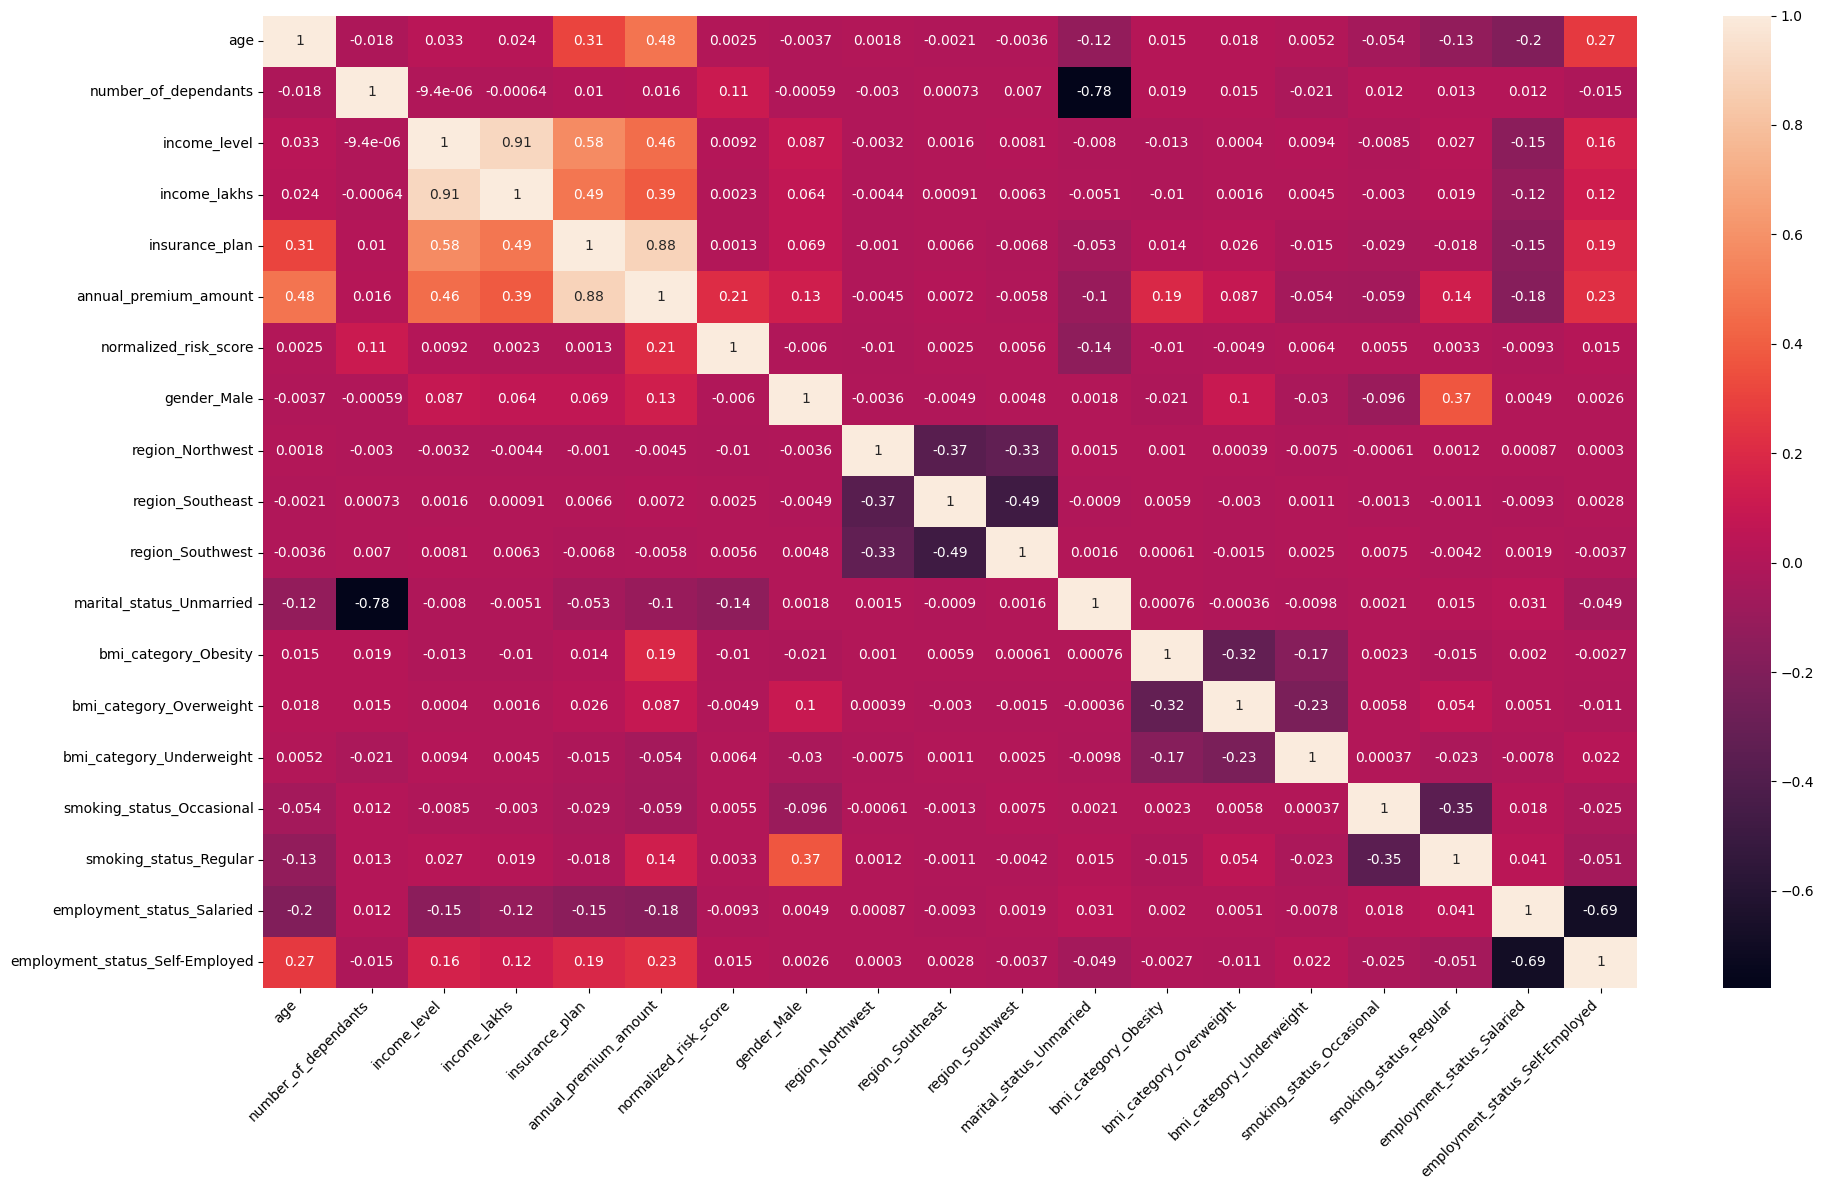

In [43]:
cm = df4.corr()

plt.figure(figsize=(20, 12))
sns.heatmap(cm, annot=True)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [44]:
X = df4.drop("annual_premium_amount", axis="columns")
y = df4["annual_premium_amount"]

from sklearn.preprocessing import MinMaxScaler

cols_to_scale = [
    "age",
    "number_of_dependants",
    "income_level",
    "income_lakhs",
    "insurance_plan",
]
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000
mean,0.371628,0.477547,0.371225,0.224509,0.544112,0.426373,0.549125,0.200691,0.352693,0.301992,0.253336,0.196835,0.295051,0.110087,0.173228,0.374656,0.466132,0.354269
std,0.240053,0.284129,0.351111,0.226822,0.379009,0.240084,0.497589,0.400524,0.477816,0.459129,0.434929,0.397613,0.456073,0.313003,0.378450,0.484042,0.498860,0.478299
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.173913,0.200000,0.000000,0.060606,0.500000,0.357143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.347826,0.600000,0.333333,0.161616,0.500000,0.428571,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.565217,0.600000,0.666667,0.313131,1.000000,0.428571,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [45]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df["Column"] = data.columns
    vif_df["VIF"] = [
        variance_inflation_factor(data.values, i) for i in range(data.shape[1])
    ]
    return vif_df

In [46]:
calculate_vif(X)

,Column,VIF
0,age,3.921783
1,number_of_dependants,6.278938
2,income_level,13.890522
3,income_lakhs,11.185596
4,insurance_plan,5.271297
5,normalized_risk_score,3.810619
6,gender_Male,2.599098
7,region_Northwest,2.123965
8,region_Southeast,2.980842
9,region_Southwest,2.710097


In [47]:
calculate_vif(X.drop("income_level", axis="columns"))

,Column,VIF
0,age,3.863055
1,number_of_dependants,6.278147
2,income_lakhs,2.678102
3,insurance_plan,4.574625
4,normalized_risk_score,3.808345
5,gender_Male,2.591439
6,region_Northwest,2.123277
7,region_Southeast,2.979899
8,region_Southwest,2.708641
9,marital_status_Unmarried,2.345757


In [48]:
# we will drop income_level due to high VIF value
X_reduced = X.drop("income_level", axis="columns")

### Model Training

In [49]:
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.30, random_state=10
)

# shape of the X_train, X_test, y_train, y_test features
print("x train: ", X_train.shape)
print("x test: ", X_test.shape)
print("y train: ", y_train.shape)
print("y test: ", y_test.shape)

x train:  (20875, 17)
x test:  (8947, 17)
y train:  (20875,)
y test:  (8947,)


## LINEAR REGRESSION

In [50]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
train_score = model_lr.score(X_train, y_train)
train_score, test_score

(0.9534163989489616, 0.9538448451629948)

In [51]:
y_pred = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Linear Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

Linear Regression ==> MSE:  2183844.360312455 RMSE:  1477.7835972538248


In [52]:
model_lr.coef_

array([ 7016.23932829, -1311.76470171,  -708.19336921, 14835.98820801,
        6053.6241234 ,    37.55826883,   -55.25087215,   -19.62254288,
         -22.28967559,  -700.32019985,  3926.8127061 ,  1979.45604663,
         612.86623617,   837.3951011 ,  2800.66184334,   -45.49136706,
         243.07842087])

In [53]:
model_lr.intercept_

np.float64(5935.981289344605)

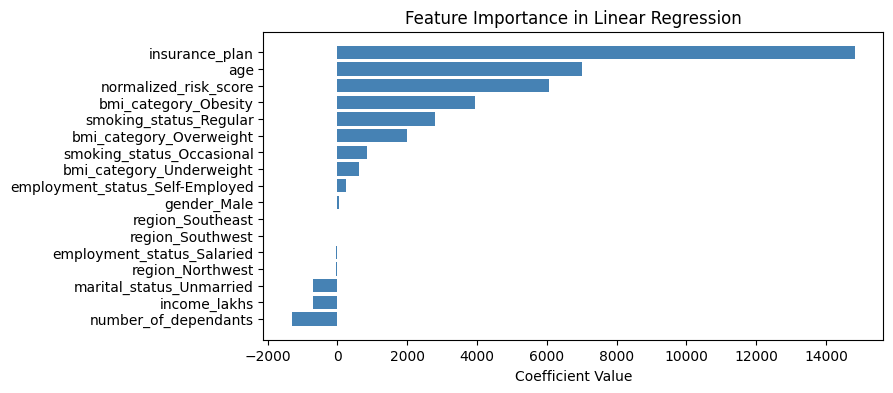

In [54]:
feature_importance = model_lr.coef_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(
    feature_importance, index=X_train.columns, columns=["Coefficients"]
)

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by="Coefficients", ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df["Coefficients"], color="steelblue")
plt.xlabel("Coefficient Value")
plt.title("Feature Importance in Linear Regression")
plt.show()

## RIDGE REGRESSION

In [55]:
model_rg = Ridge(alpha=1)
model_rg.fit(X_train, y_train)
test_score = model_rg.score(X_test, y_test)
train_score = model_rg.score(X_train, y_train)
train_score, test_score

(0.9534162332209687, 0.9538456995663842)

In [56]:
y_pred = model_rg.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Ridge Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

Ridge Regression ==> MSE:  2183803.933971563 RMSE:  1477.7699191591237


## XGBOOST

In [57]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor(n_estimators=20, max_depth=3)
model_xgb.fit(X_train, y_train)
model_xgb.score(X_test, y_test)

0.9948463439941406

In [58]:
y_pred = model_xgb.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("XGBoost Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

XGBoost Regression ==> MSE:  243847.75685001153 RMSE:  493.8094337393845


In [59]:
model_xgb = XGBRegressor()
param_grid = {
    "n_estimators": [20, 40, 50],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 4, 5],
}
random_search = RandomizedSearchCV(
    model_xgb, param_grid, n_iter=10, cv=3, scoring="r2", random_state=42, n_jobs=-1
)
random_search.fit(X_train, y_train)
random_search.best_score_

np.float64(0.9970577955245972)

In [60]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}

In [61]:
best_model = random_search.best_estimator_

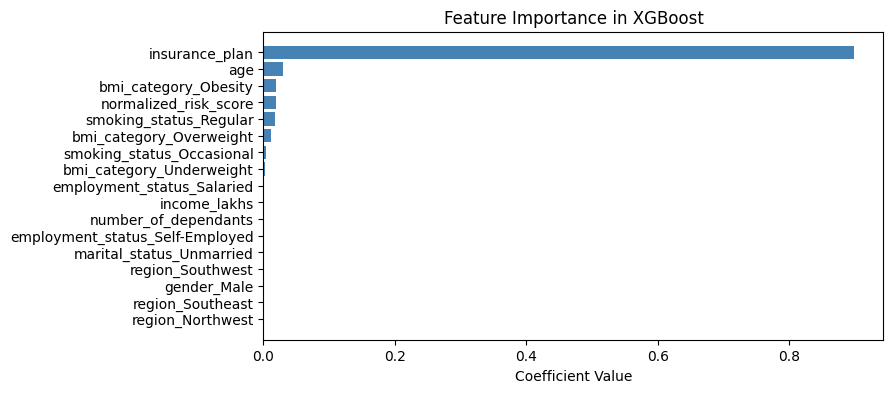

In [62]:
feature_importance = best_model.feature_importances_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(
    feature_importance, index=X_train.columns, columns=["Coefficients"]
)

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by="Coefficients", ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df["Coefficients"], color="steelblue")
plt.xlabel("Coefficient Value")
plt.title("Feature Importance in XGBoost")
plt.show()

### Error Analysis

In [63]:
y_pred = best_model.predict(X_test)

residuals = y_pred - y_test
residuals_pct = (residuals / y_test) * 100

results_df = pd.DataFrame(
    {
        "actual": y_test,
        "predicted": y_pred,
        "diff": residuals,
        "diff_pct": residuals_pct,
    }
)
results_df.head()

,actual,predicted,diff,diff_pct
19713,26895,26691.470703,-203.529297,-0.756755
14750,22734,22650.751953,-83.248047,-0.366183
19932,21198,21581.894531,383.894531,1.810994
29643,9100,9425.934570,325.934570,3.581699
17076,26434,26691.470703,257.470703,0.974013


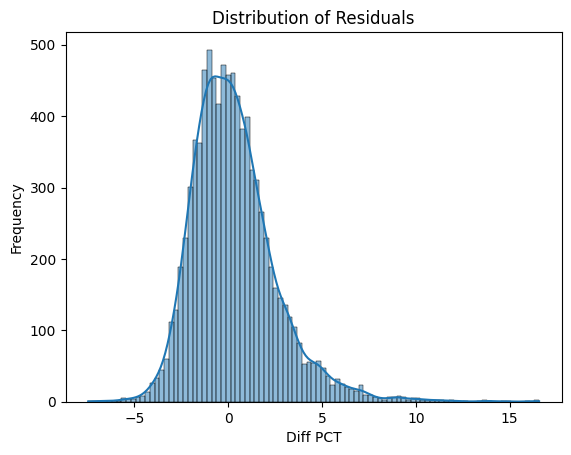

In [64]:
sns.histplot(results_df["diff_pct"], kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Diff PCT")
plt.ylabel("Frequency")
plt.show()

In [65]:
extreme_error_threshold = (
    10  # we can adjust this threshold based on our domain knowledge or requirements
)
extreme_results_df = results_df[
    np.abs(results_df["diff_pct"]) > extreme_error_threshold
]
extreme_results_df.head()

,actual,predicted,diff,diff_pct
14286,6845,7621.263672,776.263672,11.340594
27518,8502,9425.934570,923.934570,10.867261
9285,6872,7621.263672,749.263672,10.903138
7547,6538,7621.263672,1083.263672,16.568732
21910,6651,7621.263672,970.263672,14.588237


In [66]:
extreme_results_df.shape

(29, 4)

In [67]:
extreme_errors_pct = extreme_results_df.shape[0] * 100 / X_test.shape[0]
extreme_errors_pct

0.32413099362914943

In [68]:
extreme_results_df[abs(extreme_results_df.diff_pct) > 50].sort_values(
    "diff_pct", ascending=False
)

,actual,predicted,diff,diff_pct


In [69]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
14286,0.021739,0.6,0.050505,0.0,0.000000,1,1,0,0,1,0,0,0,0,0,1,0
27518,0.304348,0.6,0.080808,0.0,0.357143,1,1,0,0,0,0,0,0,0,0,0,1
9285,0.326087,0.6,0.010101,0.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
7547,0.347826,0.2,0.080808,0.0,0.000000,1,0,1,0,1,0,0,0,0,0,1,0
21910,0.043478,0.6,0.020202,0.0,0.000000,1,0,1,0,0,0,0,0,0,0,0,0


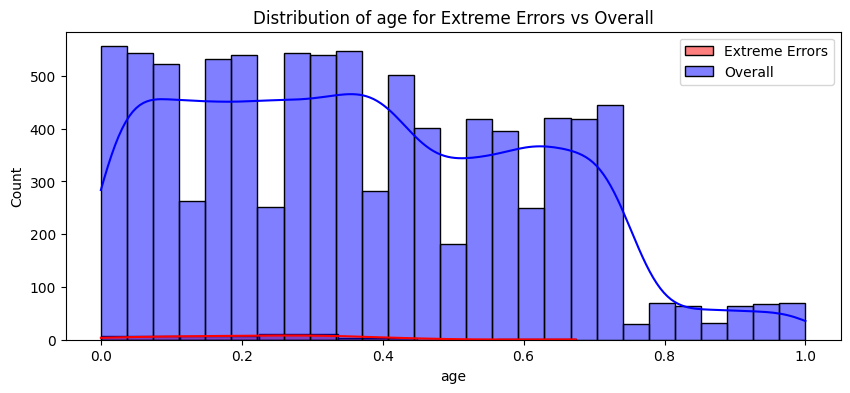

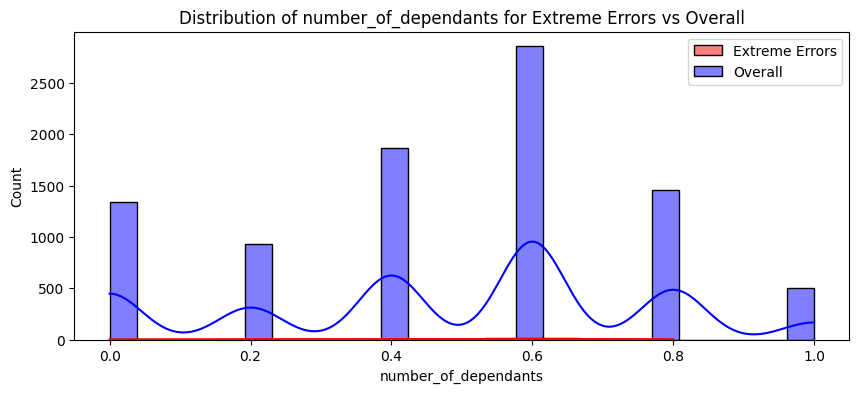

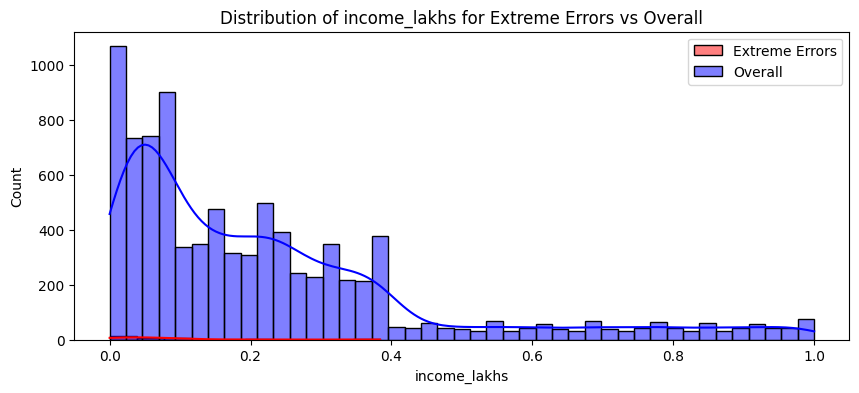

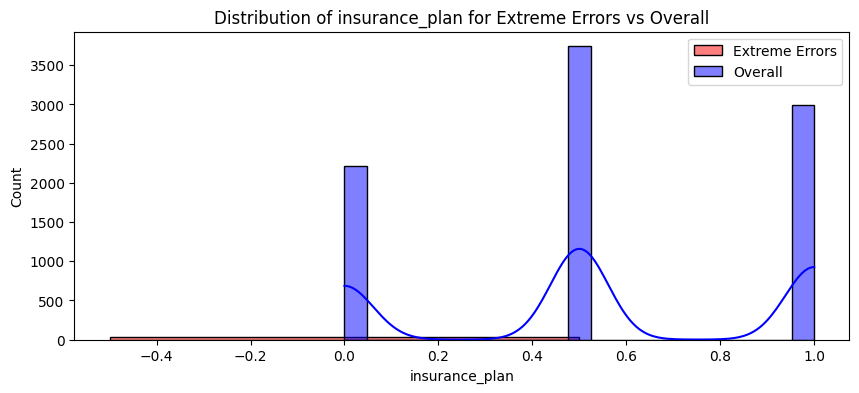

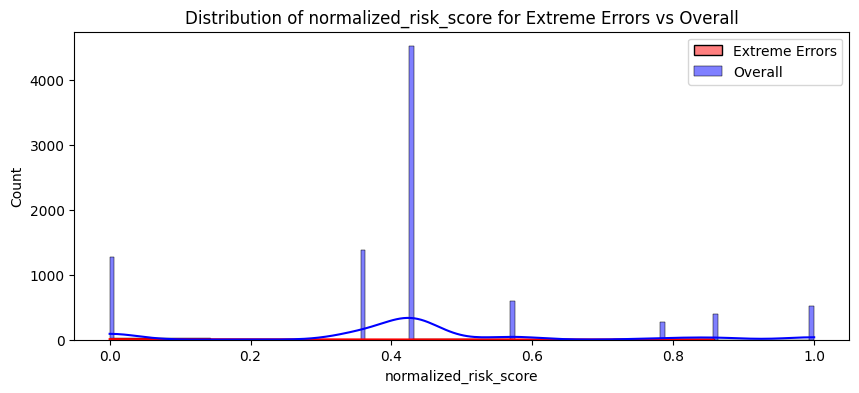

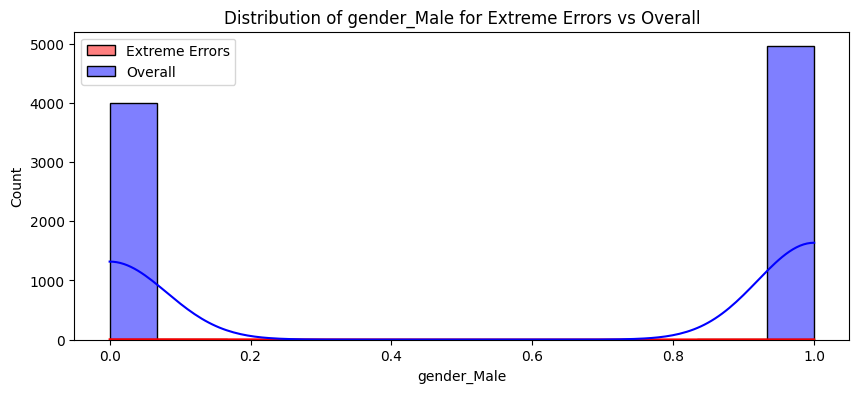

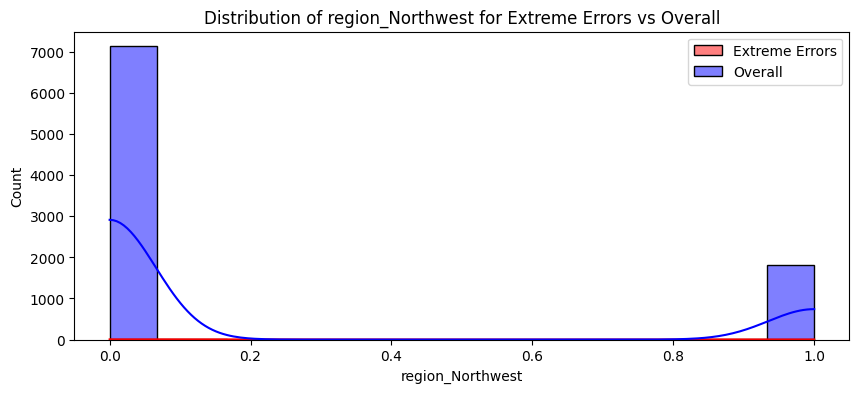

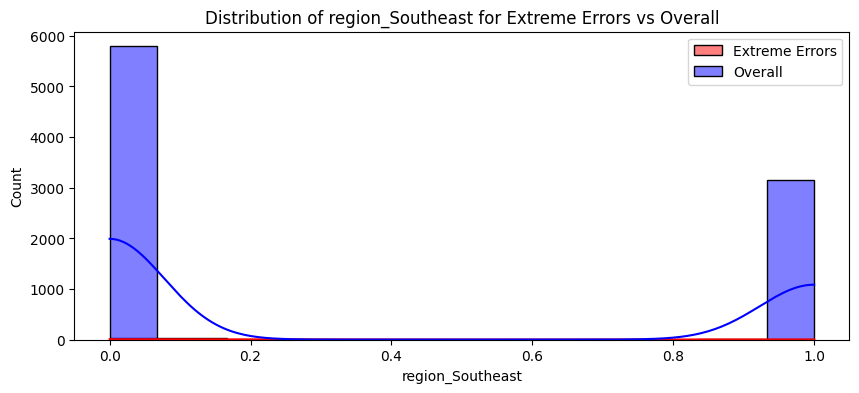

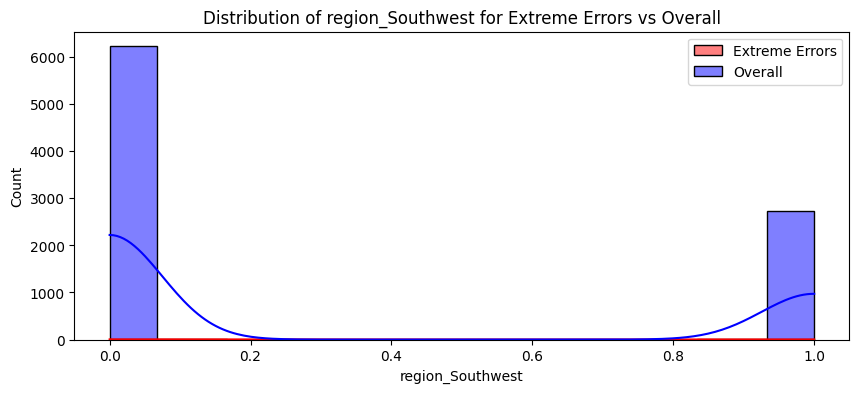

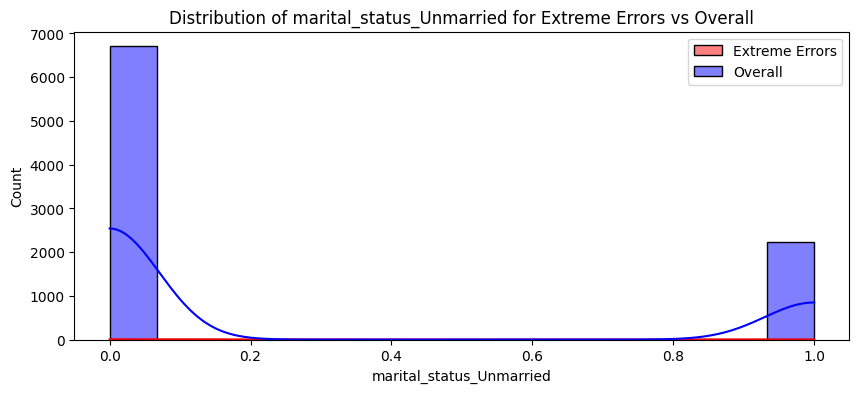

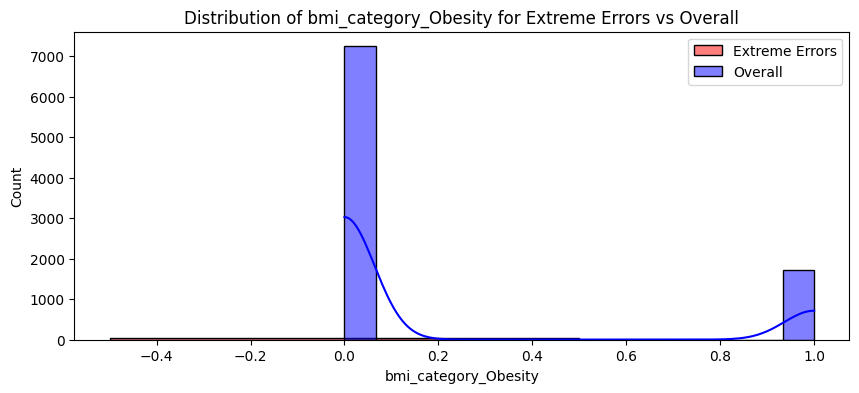

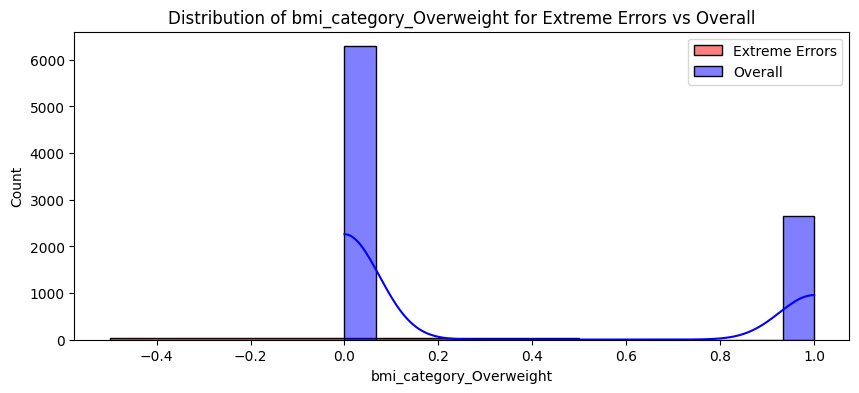

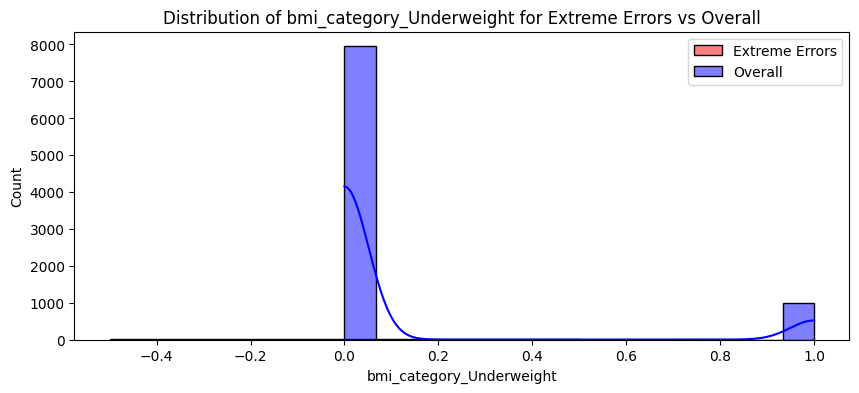

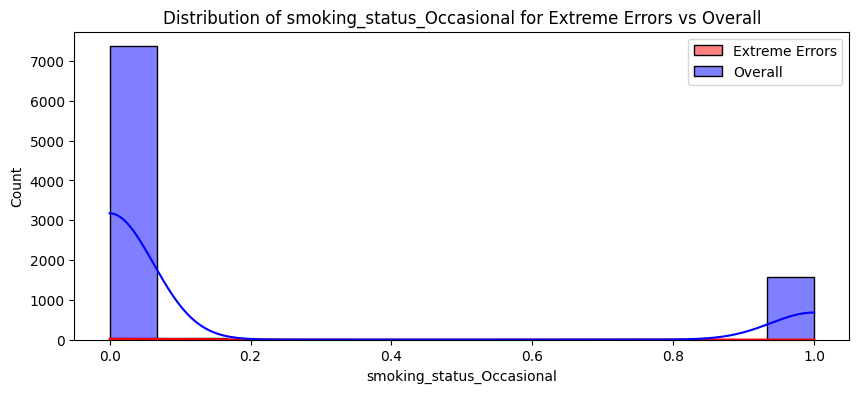

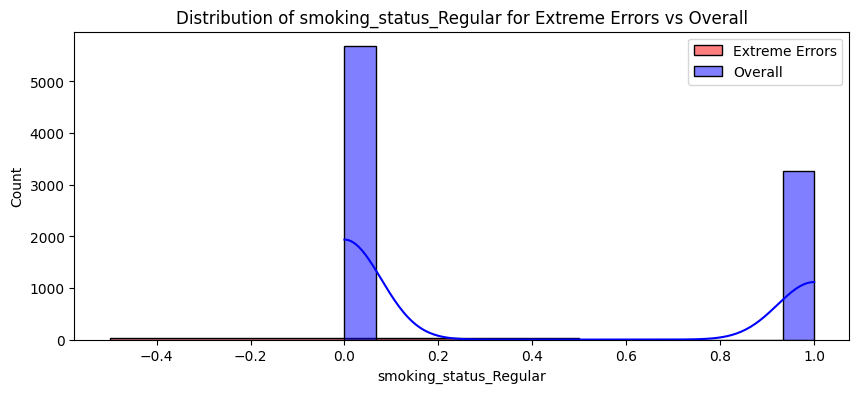

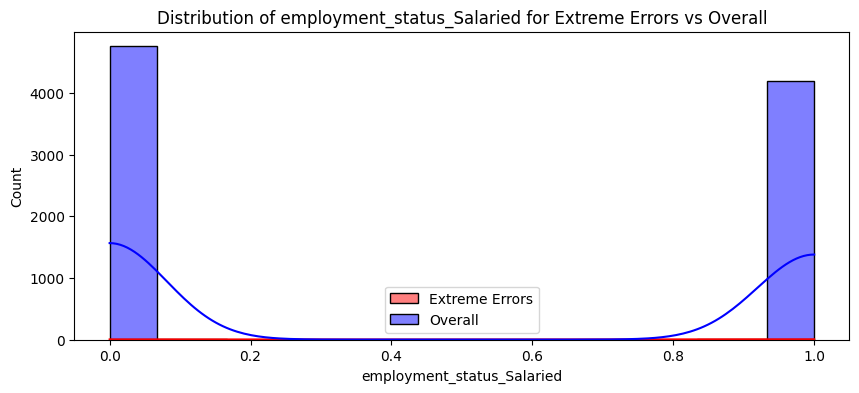

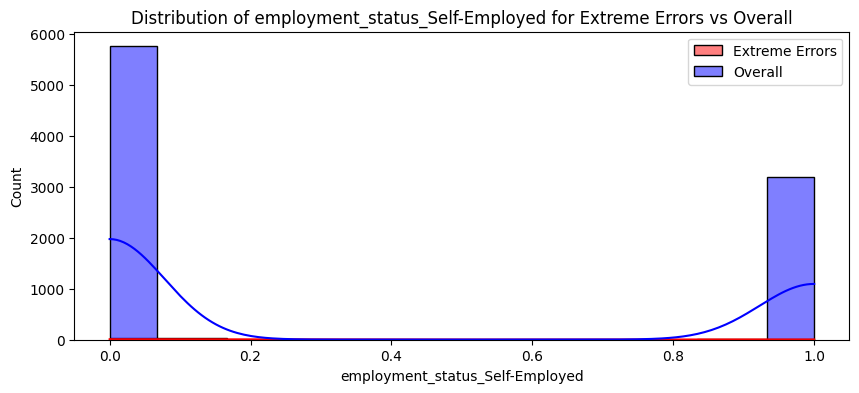

In [70]:
for feature in X_test.columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(
        extreme_errors_df[feature], color="red", label="Extreme Errors", kde=True
    )
    sns.histplot(X_test[feature], color="blue", label="Overall", alpha=0.5, kde=True)
    plt.legend()
    plt.title(f"Distribution of {feature} for Extreme Errors vs Overall")
    plt.show()

### Reverse Scaling

In [71]:
extreme_errors_df["income_level"] = -1

In [72]:
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_errors_df[cols_to_scale])
df_reversed.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
0,27.0,3.0,-2.0,6.0,1.0
1,40.0,3.0,-2.0,9.0,1.0
2,41.0,3.0,-2.0,2.0,1.0
3,42.0,1.0,-2.0,9.0,1.0
4,28.0,3.0,-2.0,3.0,1.0


In [73]:
df_reversed.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
count,29.000000,29.000000,29.0,29.000000,29.0
mean,36.586207,2.241379,-2.0,6.862069,1.0
std,6.811321,1.184880,0.0,7.619168,0.0
min,26.000000,0.000000,-2.0,1.000000,1.0
25%,32.000000,1.000000,-2.0,3.000000,1.0
50%,37.000000,3.000000,-2.0,5.000000,1.0
75%,40.000000,3.000000,-2.0,9.000000,1.0
max,57.000000,4.000000,-2.0,39.000000,1.0


<Axes: xlabel='age', ylabel='Count'>

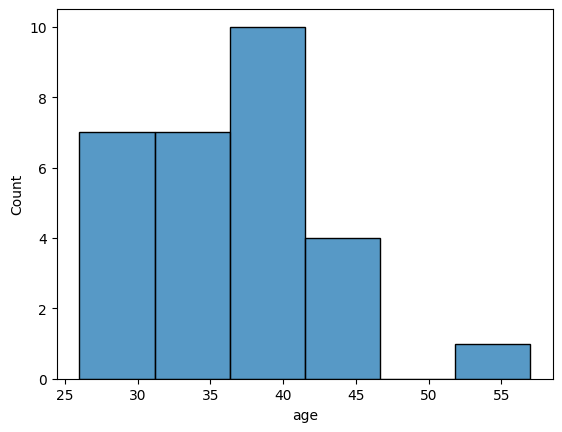

In [74]:
sns.histplot(df_reversed.age)